# Brain Tumor Detection using Convolutional Neural Networks (CNN)

**Objective:**  
To build a CNN model that can classify MRI images into "Tumor" or "No Tumor".  
We will also allow users to upload new images and get predictions.

**Key Concepts Covered:**  
- Data Visualization  
- Data Preprocessing & Augmentation  
- CNN Model Building  
- Model Training & Validation  
- Binary Classification (similar to Logistic Regression)  
- Model Evaluation & Prediction  


## 1. Import Packages

We will import packages for:  
- Plotting & visualization (`matplotlib`)  
- Numerical operations (`numpy`)  
- Deep Learning (`tensorflow.keras`)  
- File handling (`os`)  
- File upload in notebook (`ipywidgets`)  


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.svm import SVC 
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

from ipywidgets import FileUpload
from IPython.display import display, Image as IPyImage


## 2. Set Parameters & Prepare Data

We define:  
- Dataset path  
- Image size  
- Batch size  

Then, we use **ImageDataGenerator** for data augmentation and split data into **training (80%)** and **validation (20%)** sets.


In [2]:
#Data Preparation and Augmentation
DATA_DIR = "brain_tumor_dataset"
IMAGE_SIZE = (150,150)
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,      #it splits data into 80% train and 20% validation
    rotation_range=10,
    zoom_range=0.15,
    horizontal_flip=True
)

# dataset from which the model learns
train_ds = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"        
)

#model testing during training using this dataset
val_ds = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=True
)


Found 204 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [4]:
# this shows the exact mapping that the model learns 
# tensor flow assigns classes according to alphabetical order
train_ds.class_indices

{'no': 0, 'yes': 1}

## 3. Visualize Sample Images

We will visualize 9 images from the training set to understand what our dataset looks like and also to check that it is correct.


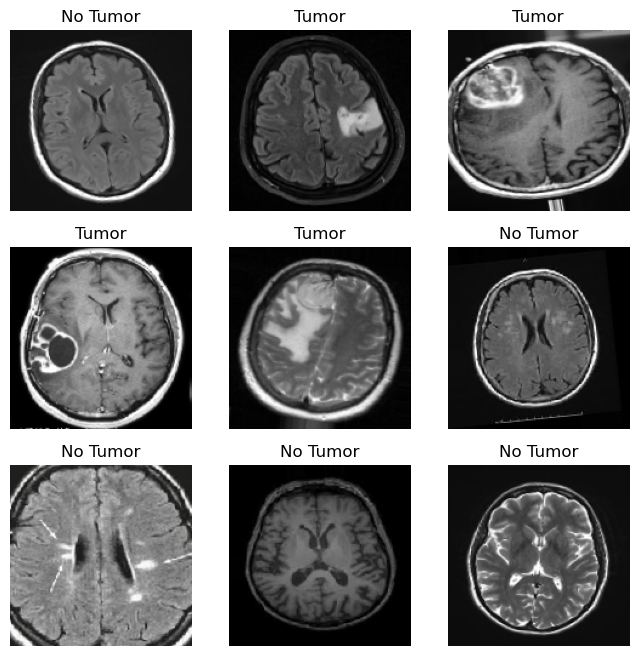

In [5]:
imgs, labels = next(train_ds)
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i])
    plt.title("Tumor" if labels[i]==1 else "No Tumor")
    plt.axis("off")
plt.show()


## 4. Build CNN Model

- **Conv2D + MaxPooling2D:** Detect patterns in images  
- **Flatten + Dense:** Prepare for classification  
- **Dropout:** Reduce overfitting  
- **Sigmoid activation:** Predict probability for binary classification  


In [6]:
model = Sequential([
    #--------------1st convolution block-------------------
    # 32 filters, 3X3 kernel, relu activation
    Conv2D(32, (3,3), activation='relu', input_shape=(*IMAGE_SIZE,3)),
    # 2x2 pool, reduces spatial size -> keeps important features
    MaxPooling2D(2,2),

    #---------------2nd convolution block ------------------
    Conv2D(64, (3,3), activation='relu'), #more filters -> deeper features
    MaxPooling2D(2,2),

    #---------------3rd convolution block-------------------
    Conv2D(128, (3,3), activation='relu'), #more filters 
    MaxPooling2D(2,2),

    #----------------------flatten--------------------------
    #converts 2d feature maps into 1d vector
    Flatten(),

    #----------------------dense----------------------------
    Dense(128, activation='relu'),
    Dropout(0.4), #randomly turns off 40% neurons -> prevents overfitting

    #---------------------output layer-----------------------
    Dense(1, activation='sigmoid')
])

#compile the model
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary() #summarize the model


C:\Users\singl\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the Model

- Train the CNN using the training dataset  
- Validate using validation dataset  
- Store history to visualize accuracy and loss later  


In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 796ms/step - accuracy: 0.6225 - loss: 0.6382 - val_accuracy: 0.6400 - val_loss: 0.5987
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 663ms/step - accuracy: 0.7157 - loss: 0.5920 - val_accuracy: 0.7000 - val_loss: 0.5822
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 670ms/step - accuracy: 0.7500 - loss: 0.5457 - val_accuracy: 0.7000 - val_loss: 0.6209
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 678ms/step - accuracy: 0.7157 - loss: 0.5247 - val_accuracy: 0.6600 - val_loss: 0.5844
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 659ms/step - accuracy: 0.7304 - loss: 0.5357 - val_accuracy: 0.7600 - val_loss: 0.5786
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 665ms/step - accuracy: 0.7598 - loss: 0.5302 - val_accuracy: 0.7600 - val_loss: 0.5546
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 646ms/step - accuracy: 0.7941 - loss: 0.4798 - val_accuracy: 0.7400 - val_loss: 0.5583
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 661ms/step - accuracy: 0.7696 - loss: 0.5270 - val_accuracy: 

## 6. Save Trained Model

Saving the model allows us to reuse it later without retraining.


In [8]:
model.save("brain_tumor_model.keras")
print("Model saved!")


Model saved!


## 7. Confusion Matrix and Classification Report


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step


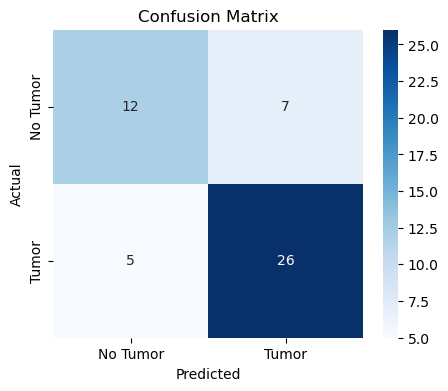


Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.71      0.63      0.67        19
       Tumor       0.79      0.84      0.81        31

    accuracy                           0.76        50
   macro avg       0.75      0.74      0.74        50
weighted avg       0.76      0.76      0.76        50



In [9]:
# Get true labels for validation set
val_labels = []
val_images = []

for batch_img, batch_label in val_ds:
    val_images.append(batch_img)
    val_labels.append(batch_label)
    if len(val_labels) * BATCH_SIZE >= val_ds.samples:
        break

val_images = np.vstack(val_images)
val_labels = np.hstack(val_labels)

# Predict on validation images
val_preds = model.predict(val_images)
val_preds_binary = (val_preds > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds_binary)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds_binary, target_names=['No Tumor', 'Tumor']))


## 8. Upload & Predict on New Images

- Users can upload a new MRI image  
- Image is preprocessed to match training data  
- Model predicts whether a tumor is present or not  
- Displays confidence score


In [3]:
model = tf.keras.models.load_model("brain_tumor_model.keras")

uploader = FileUpload(accept='.jpg,.png,.jpeg', multiple=False)
display(uploader)

def on_upload(change):
    if uploader.value:
        
        # Since uploader.value is a tuple → get the first element
        file_info = uploader.value[0]

        print("Uploaded:", file_info['name'])
        display(IPyImage(file_info['content'], width=200))

        # Convert uploaded bytes → tensor
        img_bytes = bytes(file_info['content'])
        img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)

        # Convert to float and resize
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, IMAGE_SIZE)

        # Expand dims → shape: (1, 150, 150, 3)
        img = tf.expand_dims(img, 0)

        # Predict
        pred = model.predict(img)[0][0]

        # Label
        label = "Tumor Detected" if pred > 0.5 else "No Tumor"

        # Print result
        print("\nPrediction:", label)
        print("Confidence Score:", round(float(pred), 3))


uploader.observe(on_upload, names='value')


FileUpload(value=(), accept='.jpg,.png,.jpeg', description='Upload')

## 9. ROC curve


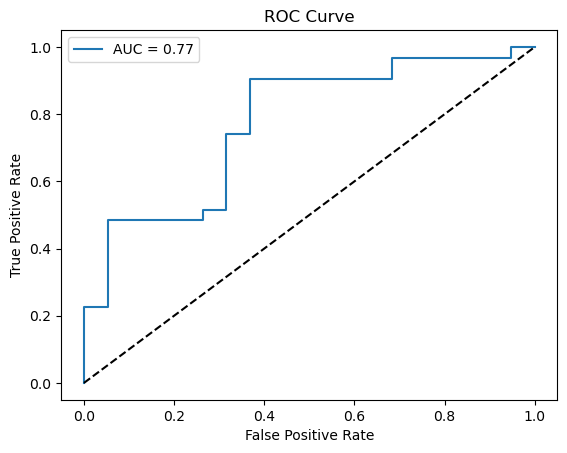

In [11]:
fpr, tpr, thresholds = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## 10. Plot Training History

Visualize **accuracy** and **loss** over epochs to check if the model is learning properly.


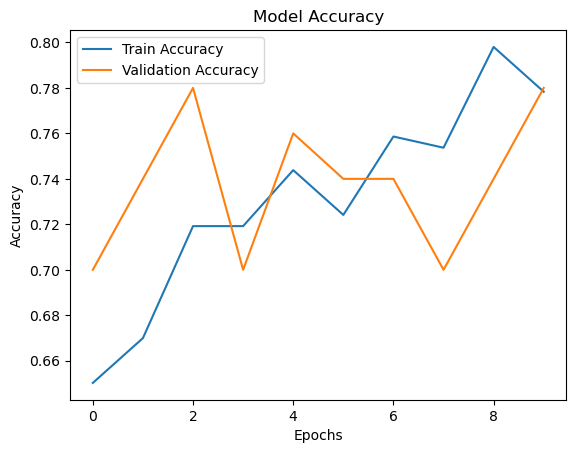

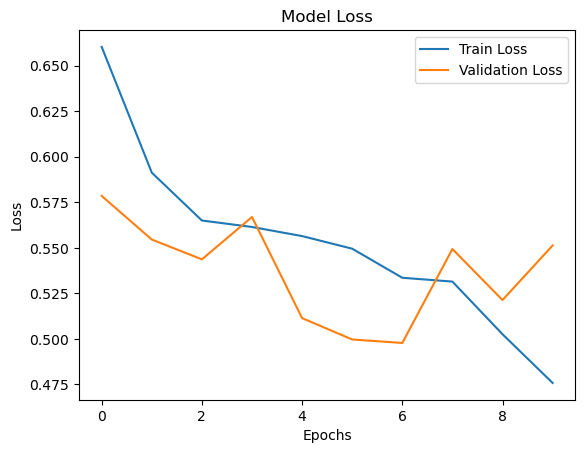

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
